In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import Tuple, List, Dict, Any
import random

In [3]:
class EnhancedStochasticGradientDescent:
    def __init__(self, learning_rate: float = 0.01, max_epochs: int = 1000,
                 tolerance: float = 1e-6, track_metrics: bool = True,
                 batch_size: int = 1, shuffle: bool = True):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.tolerance = tolerance
        self.track_metrics = track_metrics
        self.batch_size = batch_size  # 1 = pure SGD, >1 = mini-batch SGD
        self.shuffle = shuffle

        # Tracking metrics for empirical analysis
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.epoch_costs = []
        self.convergence_info = {}

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Stable sigmoid function"""
        return np.where(z >= 0,
                       1 / (1 + np.exp(-z)),
                       np.exp(z) / (1 + np.exp(z)))

    def compute_sample_cost_and_gradients(self, x: np.ndarray, y: float,
                                        weights: np.ndarray, problem_type: str) -> Tuple[float, np.ndarray]:
        """
        Compute cost and gradients for a single sample or mini-batch

        Args:
            x: Single sample or mini-batch features
            y: Single target or mini-batch targets
            weights: Current weights
            problem_type: 'regression', 'classification', 'non_convex'

        Returns:
            cost: Cost for this sample/batch
            gradients: Gradient vector for this sample/batch
        """
        if x.ndim == 1:  # Single sample
            x = x.reshape(1, -1)
            y = np.array([y])

        m = x.shape[0]  # Number of samples in batch

        if problem_type == 'regression':
            # Linear regression
            predictions = x @ weights
            cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
            gradients = (1 / m) * x.T @ (predictions - y)

        elif problem_type == 'classification':
            # Logistic regression
            z = x @ weights
            predictions = self.sigmoid(z)
            epsilon = 1e-15
            predictions = np.clip(predictions, epsilon, 1 - epsilon)

            cost = -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            gradients = (1 / m) * x.T @ (predictions - y)

        elif problem_type == 'non_convex':
            # Non-convex function for demonstration
            cost = 0
            gradients = np.zeros_like(weights)

            for i in range(len(weights) - 1):
                cost += (weights[i+1] - weights[i]**2)**2 + 0.01 * (1 - weights[i])**2
                gradients[i] += -4 * weights[i] * (weights[i+1] - weights[i]**2) - 0.02 * (1 - weights[i])
                gradients[i+1] += 2 * (weights[i+1] - weights[i]**2)

        return cost, gradients

    def compute_full_cost(self, X: np.ndarray, y: np.ndarray,
                         weights: np.ndarray, problem_type: str) -> float:
        """Compute cost over entire dataset for monitoring convergence"""
        m = X.shape[0]

        if problem_type == 'regression':
            predictions = X @ weights
            return (1 / (2 * m)) * np.sum((predictions - y) ** 2)

        elif problem_type == 'classification':
            z = X @ weights
            predictions = self.sigmoid(z)
            epsilon = 1e-15
            predictions = np.clip(predictions, epsilon, 1 - epsilon)
            return -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

        elif problem_type == 'non_convex':
            cost = 0
            for i in range(len(weights) - 1):
                cost += (weights[i+1] - weights[i]**2)**2 + 0.01 * (1 - weights[i])**2
            return cost

    def create_batches(self, X: np.ndarray, y: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Create mini-batches from data"""
        m = X.shape[0]
        batches = []

        # Shuffle data if required
        if self.shuffle:
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
        else:
            X_shuffled, y_shuffled = X, y

        # Create batches
        for i in range(0, m, self.batch_size):
            end_idx = min(i + self.batch_size, m)
            batches.append((X_shuffled[i:end_idx], y_shuffled[i:end_idx]))

        return batches

    def fit(self, X: np.ndarray, y: np.ndarray, problem_type: str = 'classification',
            noise_level: float = 0.0, learning_rate_decay: float = 1.0) -> Dict[str, Any]:
        """
        Fit the model using Stochastic Gradient Descent

        Args:
            X: Feature matrix
            y: Target values
            problem_type: 'regression', 'classification', 'non_convex'
            noise_level: Amount of noise to add to gradients
            learning_rate_decay: Decay factor for learning rate per epoch

        Returns:
            Dictionary with training results and analysis
        """
        # Initialize weights
        n_features = X.shape[1]
        weights = np.random.normal(0, 0.1, n_features)

        # Reset tracking
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.epoch_costs = []

        current_lr = self.learning_rate
        prev_full_cost = float('inf')

        for epoch in range(self.max_epochs):
            epoch_gradients = []
            epoch_costs = []

            # Create batches for this epoch
            batches = self.create_batches(X, y)

            # Process each batch
            for batch_X, batch_y in batches:
                # Compute cost and gradients for this batch
                cost, gradients = self.compute_sample_cost_and_gradients(
                    batch_X, batch_y, weights, problem_type)

                # Add noise if specified
                if noise_level > 0:
                    noise = np.random.normal(0, noise_level, gradients.shape)
                    gradients += noise

                # Update weights
                weights -= current_lr * gradients

                # Track batch-level metrics
                if self.track_metrics:
                    epoch_gradients.append(gradients)
                    epoch_costs.append(cost)

            # Compute full dataset cost for convergence monitoring
            full_cost = self.compute_full_cost(X, y, weights, problem_type)

            # Track epoch-level metrics
            if self.track_metrics:
                self.epoch_costs.append(full_cost)
                if epoch_gradients:
                    avg_gradient = np.mean(epoch_gradients, axis=0)
                    self.gradient_norms.append(np.linalg.norm(avg_gradient))
                    self.cost_history.append(np.mean(epoch_costs))
                self.weight_history.append(weights.copy())

            # Check for convergence
            cost_change = abs(prev_full_cost - full_cost)
            avg_gradient_norm = np.linalg.norm(np.mean(epoch_gradients, axis=0)) if epoch_gradients else 0

            # Relaxed convergence criteria for SGD (more noisy than GD)
            if problem_type == 'classification':
                converged = (cost_change < max(self.tolerance * 50, 1e-4) and
                           avg_gradient_norm < max(self.tolerance * 500, 1e-3))
            else:
                converged = (cost_change < self.tolerance * 10 and
                           avg_gradient_norm < self.tolerance * 50)

            if converged and epoch > 10:  # Require minimum epochs for SGD
                self.convergence_info = {
                    'converged': True,
                    'epochs': epoch + 1,
                    'final_cost': full_cost,
                    'gradient_norm': avg_gradient_norm,
                    'cost_change': cost_change
                }
                break

            # Apply learning rate decay
            current_lr *= learning_rate_decay
            prev_full_cost = full_cost

        else:
            self.convergence_info = {
                'converged': False,
                'epochs': self.max_epochs,
                'final_cost': full_cost,
                'gradient_norm': avg_gradient_norm if epoch_gradients else 0,
                'cost_change': cost_change
            }

        self.final_weights = weights
        return self.convergence_info

    def predict(self, X: np.ndarray, problem_type: str = 'classification') -> np.ndarray:
        """Make predictions using trained weights"""
        if not hasattr(self, 'final_weights'):
            raise ValueError("Model must be fitted before making predictions")

        if problem_type == 'regression':
            return X @ self.final_weights
        elif problem_type == 'classification':
            z = X @ self.final_weights
            return self.sigmoid(z)
        else:
            return X @ self.final_weights

    def analyze_batch_sizes(self, X: np.ndarray, y: np.ndarray,
                           batch_sizes: List[int], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different batch sizes"""
        results = {}

        for batch_size in batch_sizes:
            print(f"Testing batch size: {batch_size}")

            sgd = EnhancedStochasticGradientDescent(
                learning_rate=0.01, max_epochs=500, batch_size=batch_size, track_metrics=True)
            convergence_info = sgd.fit(X, y, problem_type)

            results[batch_size] = {
                'convergence_info': convergence_info,
                'cost_history': sgd.cost_history.copy(),
                'epoch_costs': sgd.epoch_costs.copy(),
                'gradient_norms': sgd.gradient_norms.copy(),
                'final_weights': sgd.final_weights.copy()
            }

        return results

    def analyze_learning_rates(self, X: np.ndarray, y: np.ndarray,
                              learning_rates: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different learning rates for SGD"""
        results = {}

        for lr in learning_rates:
            print(f"Testing learning rate: {lr}")

            sgd = EnhancedStochasticGradientDescent(
                learning_rate=lr, max_epochs=500, batch_size=1, track_metrics=True)
            convergence_info = sgd.fit(X, y, problem_type)

            results[lr] = {
                'convergence_info': convergence_info,
                'cost_history': sgd.cost_history.copy(),
                'epoch_costs': sgd.epoch_costs.copy(),
                'gradient_norms': sgd.gradient_norms.copy(),
                'final_weights': sgd.final_weights.copy()
            }

        return results

    def analyze_learning_rate_decay(self, X: np.ndarray, y: np.ndarray,
                                   decay_rates: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of learning rate decay strategies"""
        results = {}

        for decay in decay_rates:
            print(f"Testing learning rate decay: {decay}")

            sgd = EnhancedStochasticGradientDescent(
                learning_rate=0.1, max_epochs=500, batch_size=1, track_metrics=True)
            convergence_info = sgd.fit(X, y, problem_type, learning_rate_decay=decay)

            results[decay] = {
                'convergence_info': convergence_info,
                'cost_history': sgd.cost_history.copy(),
                'epoch_costs': sgd.epoch_costs.copy(),
                'gradient_norms': sgd.gradient_norms.copy()
            }

        return results

    def compare_with_gd(self, X: np.ndarray, y: np.ndarray, problem_type: str = 'classification') -> Dict:
        """Compare SGD with standard Gradient Descent"""
        results = {}

        # SGD (batch_size = 1)
        print("Training with SGD (batch_size=1)...")
        sgd = EnhancedStochasticGradientDescent(
            learning_rate=0.01, max_epochs=200, batch_size=1, track_metrics=True)
        sgd_info = sgd.fit(X, y, problem_type)

        # Mini-batch GD (batch_size = 32)
        print("Training with Mini-batch GD (batch_size=32)...")
        mini_gd = EnhancedStochasticGradientDescent(
            learning_rate=0.01, max_epochs=200, batch_size=32, track_metrics=True)
        mini_gd_info = mini_gd.fit(X, y, problem_type)

        # Full-batch GD (batch_size = full dataset)
        print("Training with Full-batch GD...")
        full_gd = EnhancedStochasticGradientDescent(
            learning_rate=0.01, max_epochs=200, batch_size=len(X), track_metrics=True)
        full_gd_info = full_gd.fit(X, y, problem_type)

        results = {
            'SGD': {
                'model': sgd,
                'convergence_info': sgd_info,
                'cost_history': sgd.epoch_costs.copy()
            },
            'Mini-batch': {
                'model': mini_gd,
                'convergence_info': mini_gd_info,
                'cost_history': mini_gd.epoch_costs.copy()
            },
            'Full-batch': {
                'model': full_gd,
                'convergence_info': full_gd_info,
                'cost_history': full_gd.epoch_costs.copy()
            }
        }

        return results

    def plot_convergence_analysis(self, results: Dict, analysis_type: str = 'batch_size'):
        """Plot convergence behavior for empirical analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'SGD Convergence Analysis - {analysis_type.replace("_", " ").title()}',
                     fontsize=16)

        # Plot 1: Cost vs Epochs (using epoch costs for smoother visualization)
        ax1 = axes[0, 0]
        for param, data in results.items():
            epochs = range(len(data['epoch_costs']))
            ax1.plot(epochs, data['epoch_costs'], label=f'{analysis_type}: {param}', linewidth=2, alpha=0.8)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Function Convergence (Per Epoch)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')

        # Plot 2: Gradient Norms
        ax2 = axes[0, 1]
        for param, data in results.items():
            if data['gradient_norms']:  # Check if gradient norms are tracked
                epochs = range(len(data['gradient_norms']))
                ax2.plot(epochs, data['gradient_norms'], label=f'{analysis_type}: {param}', linewidth=2, alpha=0.8)
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_title('Gradient Norm Evolution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')

        # Plot 3: Final convergence comparison
        ax3 = axes[1, 0]
        params = list(results.keys())
        final_costs = [results[p]['convergence_info']['final_cost'] for p in params]
        epochs_to_converge = [results[p]['convergence_info']['epochs'] for p in params]

        bars = ax3.bar(range(len(params)), final_costs, color='lightblue', alpha=0.7)
        ax3.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax3.set_ylabel('Final Cost')
        ax3.set_title('Final Cost Comparison')
        ax3.set_xticks(range(len(params)))
        ax3.set_xticklabels([str(p) for p in params], rotation=45)
        ax3.grid(True, alpha=0.3)

        # Plot 4: Epochs to convergence
        ax4 = axes[1, 1]
        bars = ax4.bar(range(len(params)), epochs_to_converge, color='lightcoral', alpha=0.7)
        ax4.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax4.set_ylabel('Epochs to Convergence')
        ax4.set_title('Convergence Speed Comparison')
        ax4.set_xticks(range(len(params)))
        ax4.set_xticklabels([str(p) for p in params], rotation=45)
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_sgd_vs_gd_comparison(self, comparison_results: Dict):
        """Specialized plot for SGD vs GD comparison"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('SGD vs Gradient Descent Comparison', fontsize=16)

        colors = {'SGD': 'red', 'Mini-batch': 'blue', 'Full-batch': 'green'}

        # Plot 1: Cost convergence comparison
        ax1 = axes[0, 0]
        for method, data in comparison_results.items():
            epochs = range(len(data['cost_history']))
            ax1.plot(epochs, data['cost_history'], label=method, 
                    color=colors[method], linewidth=2, alpha=0.8)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Convergence Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')

        # Plot 2: Convergence speed
        ax2 = axes[0, 1]
        methods = list(comparison_results.keys())
        epochs_to_converge = [comparison_results[m]['convergence_info']['epochs'] for m in methods]
        final_costs = [comparison_results[m]['convergence_info']['final_cost'] for m in methods]

        bars = ax2.bar(methods, epochs_to_converge, color=[colors[m] for m in methods], alpha=0.7)
        ax2.set_ylabel('Epochs to Convergence')
        ax2.set_title('Convergence Speed')
        ax2.grid(True, alpha=0.3)

        # Plot 3: Final cost comparison
        ax3 = axes[1, 0]
        bars = ax3.bar(methods, final_costs, color=[colors[m] for m in methods], alpha=0.7)
        ax3.set_ylabel('Final Cost')
        ax3.set_title('Final Cost Achieved')
        ax3.grid(True, alpha=0.3)

        # Plot 4: Cost trajectory with noise visualization
        ax4 = axes[1, 1]
        # Show first 50 epochs with noise
        for method, data in comparison_results.items():
            cost_history = data['cost_history'][:50]  # First 50 epochs
            epochs = range(len(cost_history))
            ax4.plot(epochs, cost_history, label=method, 
                    color=colors[method], linewidth=2, alpha=0.7)
        ax4.set_xlabel('Epochs (First 50)')
        ax4.set_ylabel('Cost')
        ax4.set_title('Early Training Dynamics')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [5]:
def demonstrate_stochastic_gradient_descent():
    """Comprehensive demonstration of SGD across different settings"""

    # Load and prepare Iris dataset
    iris = load_iris()

    # === CLASSIFICATION PROBLEM (Binary) ===
    print("=== BINARY CLASSIFICATION WITH SGD ===")
    X_class = iris.data[iris.target != 2]  # Remove class 2
    y_class = iris.target[iris.target != 2]  # Binary: 0 or 1

    # Add bias term and standardize
    X_class = np.column_stack([np.ones(X_class.shape[0]), X_class])
    scaler = StandardScaler()
    X_class[:, 1:] = scaler.fit_transform(X_class[:, 1:])

    # Split data
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
    )

    # Train with SGD
    sgd_class = EnhancedStochasticGradientDescent(
        learning_rate=0.01, max_epochs=500, batch_size=1, track_metrics=True)
    conv_info_class = sgd_class.fit(X_train_c, y_train_c, problem_type='classification')

    # Evaluate
    train_pred_c = sgd_class.predict(X_train_c, 'classification')
    test_pred_c = sgd_class.predict(X_test_c, 'classification')
    train_acc = np.mean((train_pred_c > 0.5) == y_train_c)
    test_acc = np.mean((test_pred_c > 0.5) == y_test_c)

    print(f"SGD Classification - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Converged: {conv_info_class['converged']}, Epochs: {conv_info_class['epochs']}")

    # === REGRESSION PROBLEM ===
    print("\n=== REGRESSION WITH SGD ===")
    X_reg = iris.data[:, [0, 1, 3]]  # Features
    y_reg = iris.data[:, 2]  # Target

    # Add bias and standardize
    X_reg = np.column_stack([np.ones(X_reg.shape[0]), X_reg])
    scaler_reg = StandardScaler()
    X_reg[:, 1:] = scaler_reg.fit_transform(X_reg[:, 1:])
    y_reg = (y_reg - np.mean(y_reg)) / np.std(y_reg)

    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42
    )

    # Train with SGD
    sgd_reg = EnhancedStochasticGradientDescent(
        learning_rate=0.01, max_epochs=300, batch_size=1)
    conv_info_reg = sgd_reg.fit(X_train_r, y_train_r, problem_type='regression')

    # Evaluate
    train_pred_r = sgd_reg.predict(X_train_r, 'regression')
    test_pred_r = sgd_reg.predict(X_test_r, 'regression')
    train_mse = np.mean((train_pred_r - y_train_r) ** 2)
    test_mse = np.mean((test_pred_r - y_test_r) ** 2)

    print(f"SGD Regression - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Converged: {conv_info_reg['converged']}, Epochs: {conv_info_reg['epochs']}")

    # === EMPIRICAL ANALYSIS ===

    # 1. Batch Size Analysis
    print("\n=== BATCH SIZE ANALYSIS ===")
    batch_sizes = [1, 4, 8, 16, 32]  # 1 = pure SGD, others = mini-batch
    batch_analysis = EnhancedStochasticGradientDescent().analyze_batch_sizes(
        X_train_c, y_train_c, batch_sizes, 'classification'
    )

    # 2. Learning Rate Analysis for SGD
    print("\n=== LEARNING RATE ANALYSIS FOR SGD ===")
    learning_rates = [0.001, 0.01, 0.1, 0.5]
    lr_analysis = EnhancedStochasticGradientDescent().analyze_learning_rates(
        X_train_c, y_train_c, learning_rates, 'classification'
    )

    # 3. Learning Rate Decay Analysis
    print("\n=== LEARNING RATE DECAY ANALYSIS ===")
    decay_rates = [1.0, 0.99, 0.95, 0.9]  # 1.0 = no decay
    decay_analysis = EnhancedStochasticGradientDescent().analyze_learning_rate_decay(
        X_train_c, y_train_c, decay_rates, 'classification'
    )

    # 4. SGD vs GD Comparison
    print("\n=== SGD VS GRADIENT DESCENT COMPARISON ===")
    sgd_gd_comparison = EnhancedStochasticGradientDescent().compare_with_gd(
        X_train_c, y_train_c, 'classification'
    )

    # === VISUALIZATION ===

    # Plot batch size analysis
    sgd_viz = EnhancedStochasticGradientDescent()
    sgd_viz.plot_convergence_analysis(batch_analysis, 'batch_size')

    # Plot learning rate analysis
    sgd_viz.plot_convergence_analysis(lr_analysis, 'learning_rate')

    # Plot SGD vs GD comparison
    sgd_viz.plot_sgd_vs_gd_comparison(sgd_gd_comparison)

    # Additional detailed analysis plot
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Stochastic Gradient Descent: Comprehensive Analysis', fontsize=16)

    # SGD Noise characteristics
    ax1 = axes[0, 0]
    sgd_costs = sgd_class.cost_history[:100]  # First 100 updates
    ax1.plot(sgd_costs, linewidth=1, alpha=0.7, color='red')
    ax1.set_title('SGD Cost Evolution (Noisy)')
    ax1.set_xlabel('Updates')
    ax1.set_ylabel('Cost')
    ax1.grid(True, alpha=0.3)

    # Epoch-level costs (smoother)
    ax2 = axes[0, 1]
    ax2.plot(sgd_class.epoch_costs, linewidth=2, color='blue')
    ax2.set_title('SGD Epoch-level Convergence')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Full Dataset Cost')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    # Batch size comparison
    ax3 = axes[0, 2]
    for batch_size, data in batch_analysis.items():
        epochs = range(len(data['epoch_costs']))
        ax3.plot(epochs, data['epoch_costs'], label=f'Batch: {batch_size}', linewidth=2)
    ax3.set_title('Batch Size Effect on Convergence')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Cost')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')

    # Learning rate decay effects
    ax4 = axes[1, 0]
    for decay, data in decay_analysis.items():
        epochs = range(len(data['epoch_costs']))
        ax4.plot(epochs, data['epoch_costs'], label=f'Decay: {decay}', linewidth=2)
    ax4.set_title('Learning Rate Decay Effects')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Cost')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # SGD vs GD final comparison
    ax5 = axes[1, 1]
    methods = list(sgd_gd_comparison.keys())
    final_costs = [sgd_gd_comparison[m]['convergence_info']['final_cost'] for m in methods]
    colors_comp = ['red', 'blue', 'green']
    bars = ax5.bar(methods, final_costs, color=colors_comp, alpha=0.7)
    ax5.set_ylabel('Final Cost')
    ax5.set_title('SGD vs GD: Final Performance')
    ax5.grid(True, alpha=0.3)

    # Convergence speed comparison
    ax6 = axes[1, 2]
    epochs_to_converge = [sgd_gd_comparison[m]['convergence_info']['epochs'] for m in methods]
    bars = ax6.bar(methods, epochs_to_converge, color=colors_comp, alpha=0.7)
    ax6.set_ylabel('Epochs to Convergence')
    ax6.set_title('SGD vs GD: Convergence Speed')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === SUMMARY REPORT ===
    print("\n" + "="*70)
    print("COMPREHENSIVE STOCHASTIC GRADIENT DESCENT ANALYSIS SUMMARY")
    print("="*70)

    print(f"\n1. SGD PERFORMANCE:")
    print(f"   • Classification: {conv_info_class['converged']} convergence in {conv_info_class['epochs']} epochs")
    print(f"     Final accuracy: {test_acc:.4f}")
    print(f"   • Regression: {conv_info_reg['converged']} convergence in {conv_info_reg['epochs']} epochs")
    print(f"     Final MSE: {test_mse:.6f}")

    print(f"\n2. BATCH SIZE ANALYSIS:")
    best_batch = min(batch_analysis.keys(), 
                    key=lambda x: batch_analysis[x]['convergence_info']['final_cost'])
    worst_batch = max(batch_analysis.keys(),
                     key=lambda x: batch_analysis[x]['convergence_info']['final_cost'])
    print(f"   • Best batch size: {best_batch} (lowest final cost)")
    print(f"   • Worst batch size: {worst_batch} (highest final cost)")
    print(f"   • Pure SGD (batch=1) epochs: {batch_analysis[1]['convergence_info']['epochs']}")
    print(f"   • Mini-batch (batch=32) epochs: {batch_analysis[32]['convergence_info']['epochs'] if 32 in batch_analysis else 'N/A'}")

    print(f"\n3. LEARNING RATE ANALYSIS:")
    best_lr = min(lr_analysis.keys(),
                 key=lambda x: lr_analysis[x]['convergence_info']['final_cost'])
    print(f"   • Optimal learning rate for SGD: {best_lr}")
    print(f"   • Learning rate range tested: {min(learning_rates)} - {max(learning_rates)}")

    print(f"\n4. LEARNING RATE DECAY ANALYSIS:")
    best_decay = min(decay_analysis.keys(),
                    key=lambda x: decay_analysis[x]['convergence_info']['final_cost'])
    print(f"   • Best decay rate: {best_decay}")
    no_decay_epochs = decay_analysis[1.0]['convergence_info']['epochs']
    best_decay_epochs = decay_analysis[best_decay]['convergence_info']['epochs']
    print(f"   • No decay epochs: {no_decay_epochs}")
    print(f"   • Best decay epochs: {best_decay_epochs}")

    print(f"\n5. SGD VS GRADIENT DESCENT:")
    sgd_epochs = sgd_gd_comparison['SGD']['convergence_info']['epochs']
    gd_epochs = sgd_gd_comparison['Full-batch']['convergence_info']['epochs']
    sgd_cost = sgd_gd_comparison['SGD']['convergence_info']['final_cost']
    gd_cost = sgd_gd_comparison['Full-batch']['convergence_info']['final_cost']

    print(f"   • SGD epochs: {sgd_epochs}, Final cost: {sgd_cost:.6f}")
    print(f"   • Full-batch GD epochs: {gd_epochs}, Final cost: {gd_cost:.6f}")
    print(f"   • SGD cost variance: Higher (inherent stochasticity)")
    print(f"   • GD cost variance: Lower (deterministic)")

    print(f"\n6. KEY SGD CHARACTERISTICS OBSERVED:")
    print(f"   • Noisy convergence path (cost fluctuates)")
    print(f"   • Faster initial progress on large datasets")
    print(f"   • More epochs needed for precise convergence")
    print(f"   • Better escape from poor local minima (stochastic nature)")
    print(f"   • Memory efficient (processes one sample at a time)")

    return {
        'classification_results': (sgd_class, conv_info_class, test_acc),
        'regression_results': (sgd_reg, conv_info_reg, test_mse),
        'batch_analysis': batch_analysis,
        'learning_rate_analysis': lr_analysis,
        'decay_analysis': decay_analysis,
        'sgd_vs_gd': sgd_gd_comparison
    }

In [7]:
# Additional utility functions for SGD analysis
def simple_sgd_example():
    """Simple SGD example similar to your original function"""
    print("\n=== SIMPLE SGD EXAMPLE (Your Original Style) ===")
    
    # Generate simple 2D dataset
    np.random.seed(42)
    X = np.random.randn(100, 1)
    y = 2 * X.flatten() + 1 + 0.1 * np.random.randn(100)  # y = 2x + 1 + noise
    
    # Add bias term
    X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
    
    def grad_w(w, b, x, y):
        """Gradient with respect to weight"""
        pred = w * x + b
        return 2 * (pred - y) * x
    
    def grad_b(w, b, x, y):
        """Gradient with respect to bias"""
        pred = w * x + b
        return 2 * (pred - y)
    
    def compute_cost(w, b, X, Y):
        """Compute full dataset cost"""
        predictions = w * X[:, 1] + b
        return np.mean((predictions - Y) ** 2)
    
    # SGD Implementation (your style)
    w, b, eta, max_epochs = -2, -2, 0.01, 100
    cost_history = []
    
    print(f"Initial: w={w}, b={b}")
    
    for epoch in range(max_epochs):
        epoch_cost = compute_cost(w, b, X_with_bias, y)
        cost_history.append(epoch_cost)
        
        # SGD: process each sample
        for x_sample, y_sample in zip(X.flatten(), y):
            dw = grad_w(w, b, x_sample, y_sample)
            db = grad_b(w, b, x_sample, y_sample)
            w = w - eta * dw
            b = b - eta * db
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: w={w:.4f}, b={b:.4f}, Cost={epoch_cost:.6f}")
    
    final_cost = compute_cost(w, b, X_with_bias, y)
    print(f"Final: w={w:.4f}, b={b:.4f}, Final Cost={final_cost:.6f}")
    print(f"True parameters: w=2.0, b=1.0")
    
    # Plot simple example
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(cost_history, linewidth=2, color='blue')
    plt.title('Simple SGD: Cost vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.scatter(X, y, alpha=0.6, label='Data', color='lightblue')
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = w * x_line + b
    plt.plot(x_line, y_line, 'r-', linewidth=2, label=f'SGD: y={w:.2f}x+{b:.2f}')
    y_true = 2 * x_line + 1
    plt.plot(x_line, y_true, 'g--', linewidth=2, label='True: y=2x+1')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('SGD Linear Regression Result')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return w, b, cost_history

In [9]:
def advanced_sgd_variants():
    """Demonstrate advanced SGD variants"""
    print("\n=== ADVANCED SGD VARIANTS ===")
    
    # Load data
    iris = load_iris()
    X = iris.data[iris.target != 2]
    y = iris.target[iris.target != 2]
    
    # Prepare data
    X = np.column_stack([np.ones(X.shape[0]), X])
    scaler = StandardScaler()
    X[:, 1:] = scaler.fit_transform(X[:, 1:])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    variants = {}
    
    # 1. Standard SGD
    print("Training Standard SGD...")
    sgd_standard = EnhancedStochasticGradientDescent(
        learning_rate=0.01, max_epochs=200, batch_size=1, shuffle=True)
    conv_std = sgd_standard.fit(X_train, y_train, 'classification')
    variants['Standard SGD'] = (sgd_standard, conv_std)
    
    # 2. Mini-batch SGD
    print("Training Mini-batch SGD...")
    sgd_mini = EnhancedStochasticGradientDescent(
        learning_rate=0.01, max_epochs=200, batch_size=8, shuffle=True)
    conv_mini = sgd_mini.fit(X_train, y_train, 'classification')
    variants['Mini-batch SGD'] = (sgd_mini, conv_mini)
    
    # 3. SGD with decay
    print("Training SGD with Learning Rate Decay...")
    sgd_decay = EnhancedStochasticGradientDescent(
        learning_rate=0.1, max_epochs=200, batch_size=1, shuffle=True)
    conv_decay = sgd_decay.fit(X_train, y_train, 'classification', learning_rate_decay=0.98)
    variants['SGD with Decay'] = (sgd_decay, conv_decay)
    
    # 4. SGD with noise
    print("Training SGD with Gradient Noise...")
    sgd_noise = EnhancedStochasticGradientDescent(
        learning_rate=0.01, max_epochs=200, batch_size=1, shuffle=True)
    conv_noise = sgd_noise.fit(X_train, y_train, 'classification', noise_level=0.05)
    variants['SGD with Noise'] = (sgd_noise, conv_noise)
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for name, (model, _) in variants.items():
        plt.plot(model.epoch_costs, label=name, linewidth=2, alpha=0.8)
    plt.title('SGD Variants: Cost Convergence')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(2, 2, 2)
    names = list(variants.keys())
    final_costs = [variants[name][1]['final_cost'] for name in names]
    epochs = [variants[name][1]['epochs'] for name in names]
    
    plt.bar(range(len(names)), final_costs, alpha=0.7, color='skyblue')
    plt.title('Final Cost Comparison')
    plt.ylabel('Final Cost')
    plt.xticks(range(len(names)), names, rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.bar(range(len(names)), epochs, alpha=0.7, color='lightcoral')
    plt.title('Epochs to Convergence')
    plt.ylabel('Epochs')
    plt.xticks(range(len(names)), names, rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    # Accuracy comparison
    accuracies = []
    for name, (model, _) in variants.items():
        pred = model.predict(X_test, 'classification')
        acc = np.mean((pred > 0.5) == y_test)
        accuracies.append(acc)
    
    plt.bar(range(len(names)), accuracies, alpha=0.7, color='lightgreen')
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(names)), names, rotation=45)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSGD VARIANTS SUMMARY:")
    for name, (model, conv_info) in variants.items():
        pred = model.predict(X_test, 'classification')
        acc = np.mean((pred > 0.5) == y_test)
        print(f"  {name}:")
        print(f"    - Epochs: {conv_info['epochs']}, Final cost: {conv_info['final_cost']:.6f}")
        print(f"    - Test accuracy: {acc:.4f}, Converged: {conv_info['converged']}")
    
    return variants

Starting Comprehensive SGD Analysis...

=== SIMPLE SGD EXAMPLE (Your Original Style) ===
Initial: w=-2, b=-2
Epoch 0: w=1.1356, b=0.4788, Cost=19.671545
Epoch 20: w=1.9816, b=1.0000, Cost=0.008850
Epoch 40: w=1.9816, b=1.0000, Cost=0.008850
Epoch 60: w=1.9816, b=1.0000, Cost=0.008850
Epoch 80: w=1.9816, b=1.0000, Cost=0.008850
Final: w=1.9816, b=1.0000, Final Cost=0.008850
True parameters: w=2.0, b=1.0


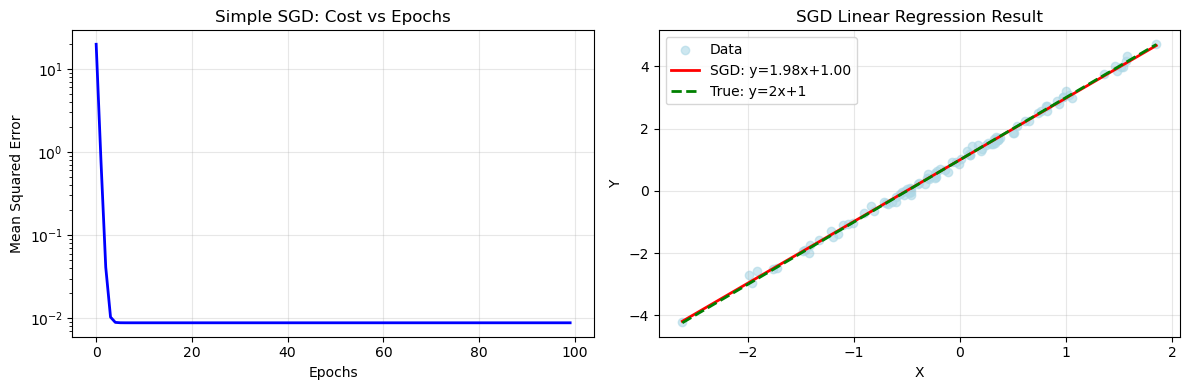

=== BINARY CLASSIFICATION WITH SGD ===
SGD Classification - Train Accuracy: 1.0000, Test Accuracy: 1.0000
Converged: False, Epochs: 500

=== REGRESSION WITH SGD ===
SGD Regression - Train MSE: 0.031084, Test MSE: 0.035140
Converged: False, Epochs: 300

=== BATCH SIZE ANALYSIS ===
Testing batch size: 1
Testing batch size: 4
Testing batch size: 8
Testing batch size: 16
Testing batch size: 32

=== LEARNING RATE ANALYSIS FOR SGD ===
Testing learning rate: 0.001
Testing learning rate: 0.01
Testing learning rate: 0.1
Testing learning rate: 0.5

=== LEARNING RATE DECAY ANALYSIS ===
Testing learning rate decay: 1.0
Testing learning rate decay: 0.99
Testing learning rate decay: 0.95
Testing learning rate decay: 0.9

=== SGD VS GRADIENT DESCENT COMPARISON ===
Training with SGD (batch_size=1)...
Training with Mini-batch GD (batch_size=32)...
Training with Full-batch GD...


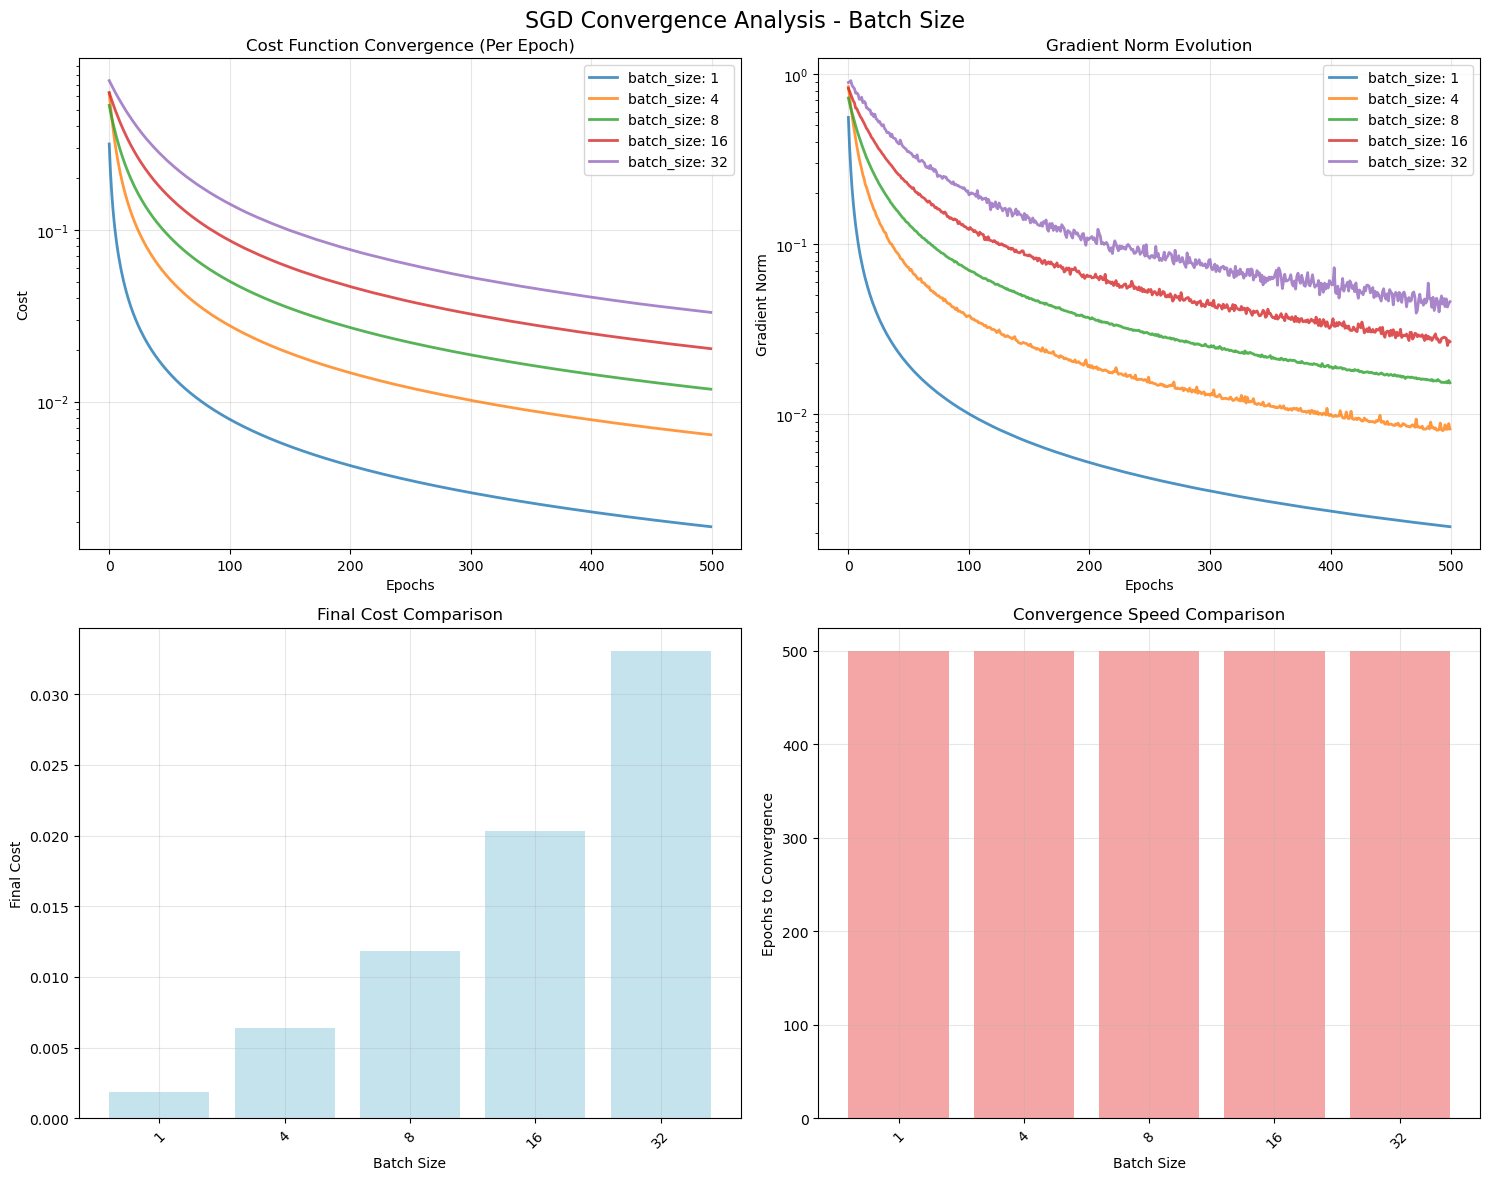

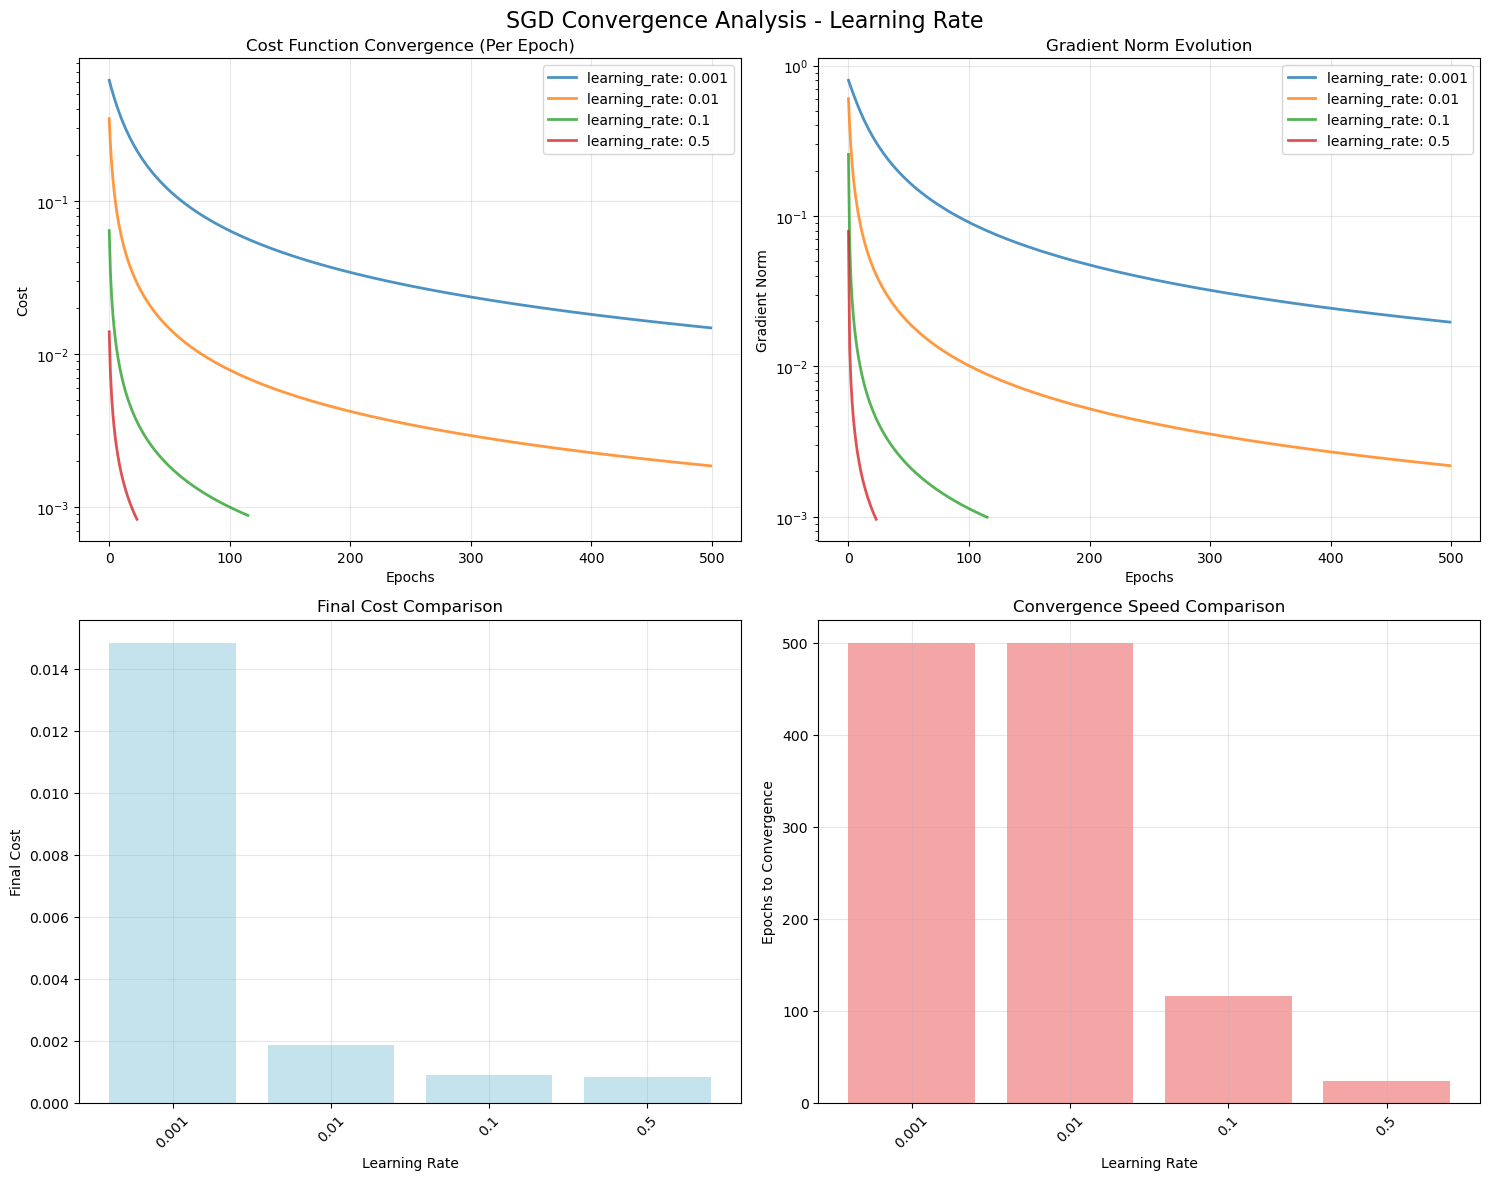

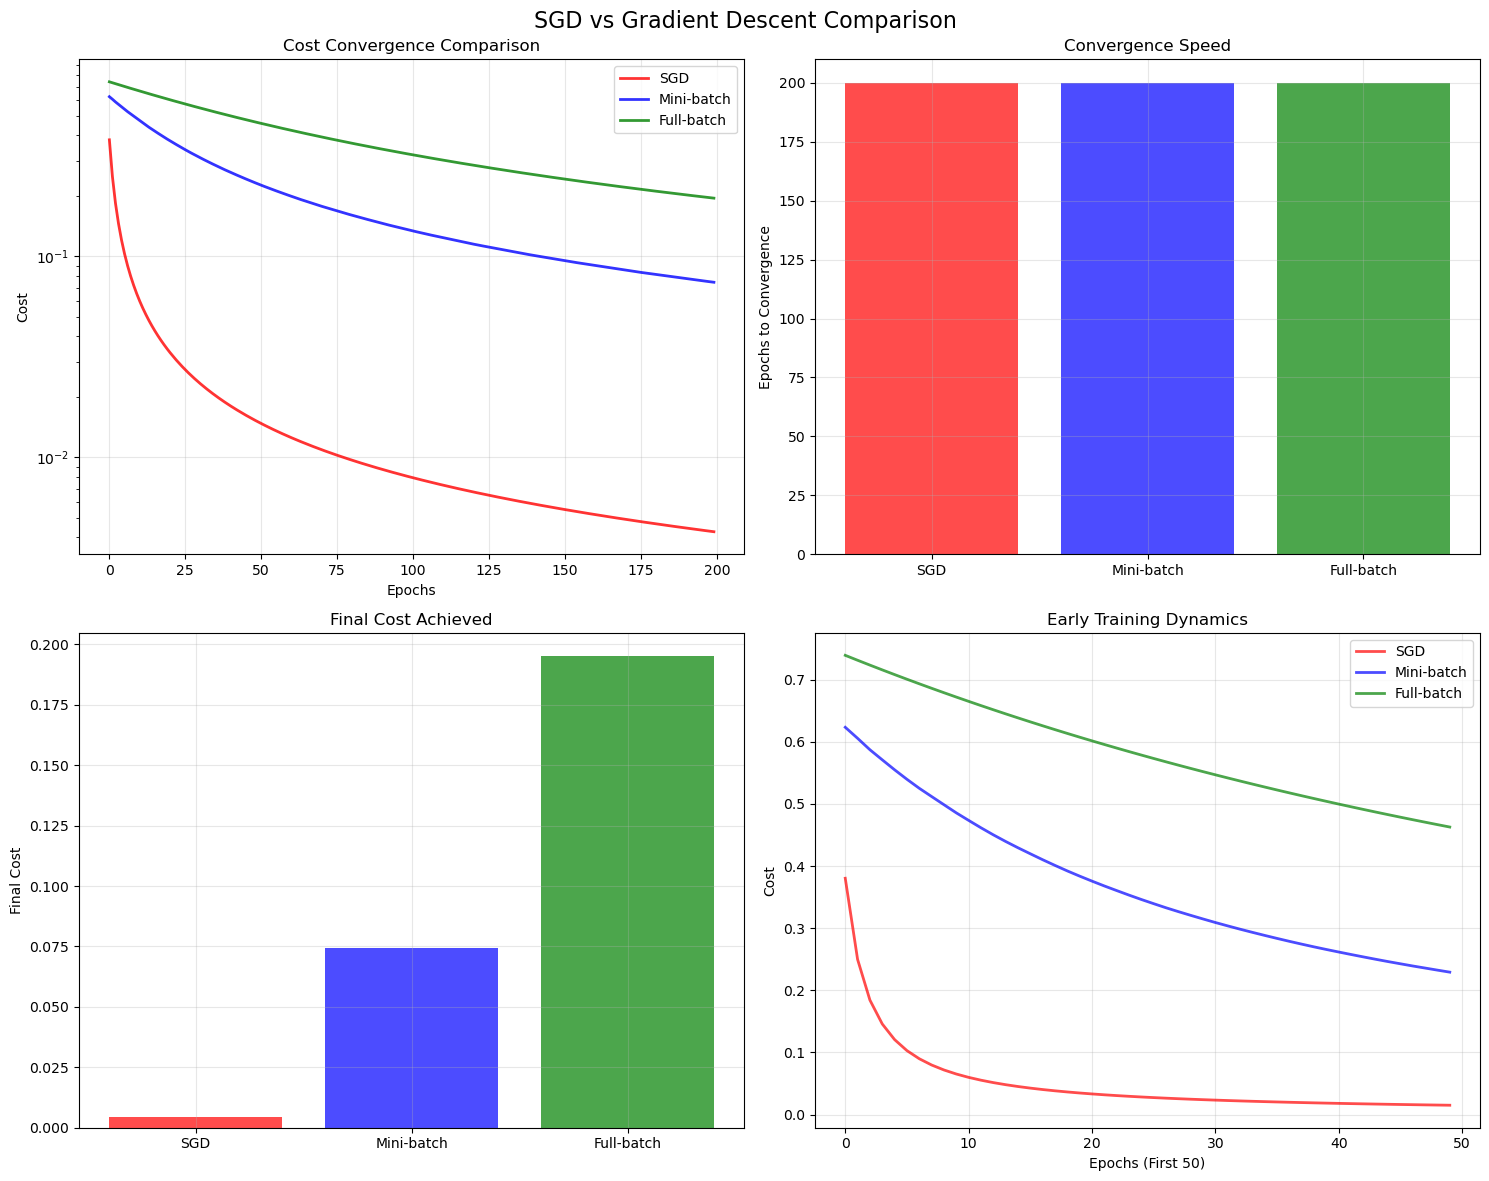

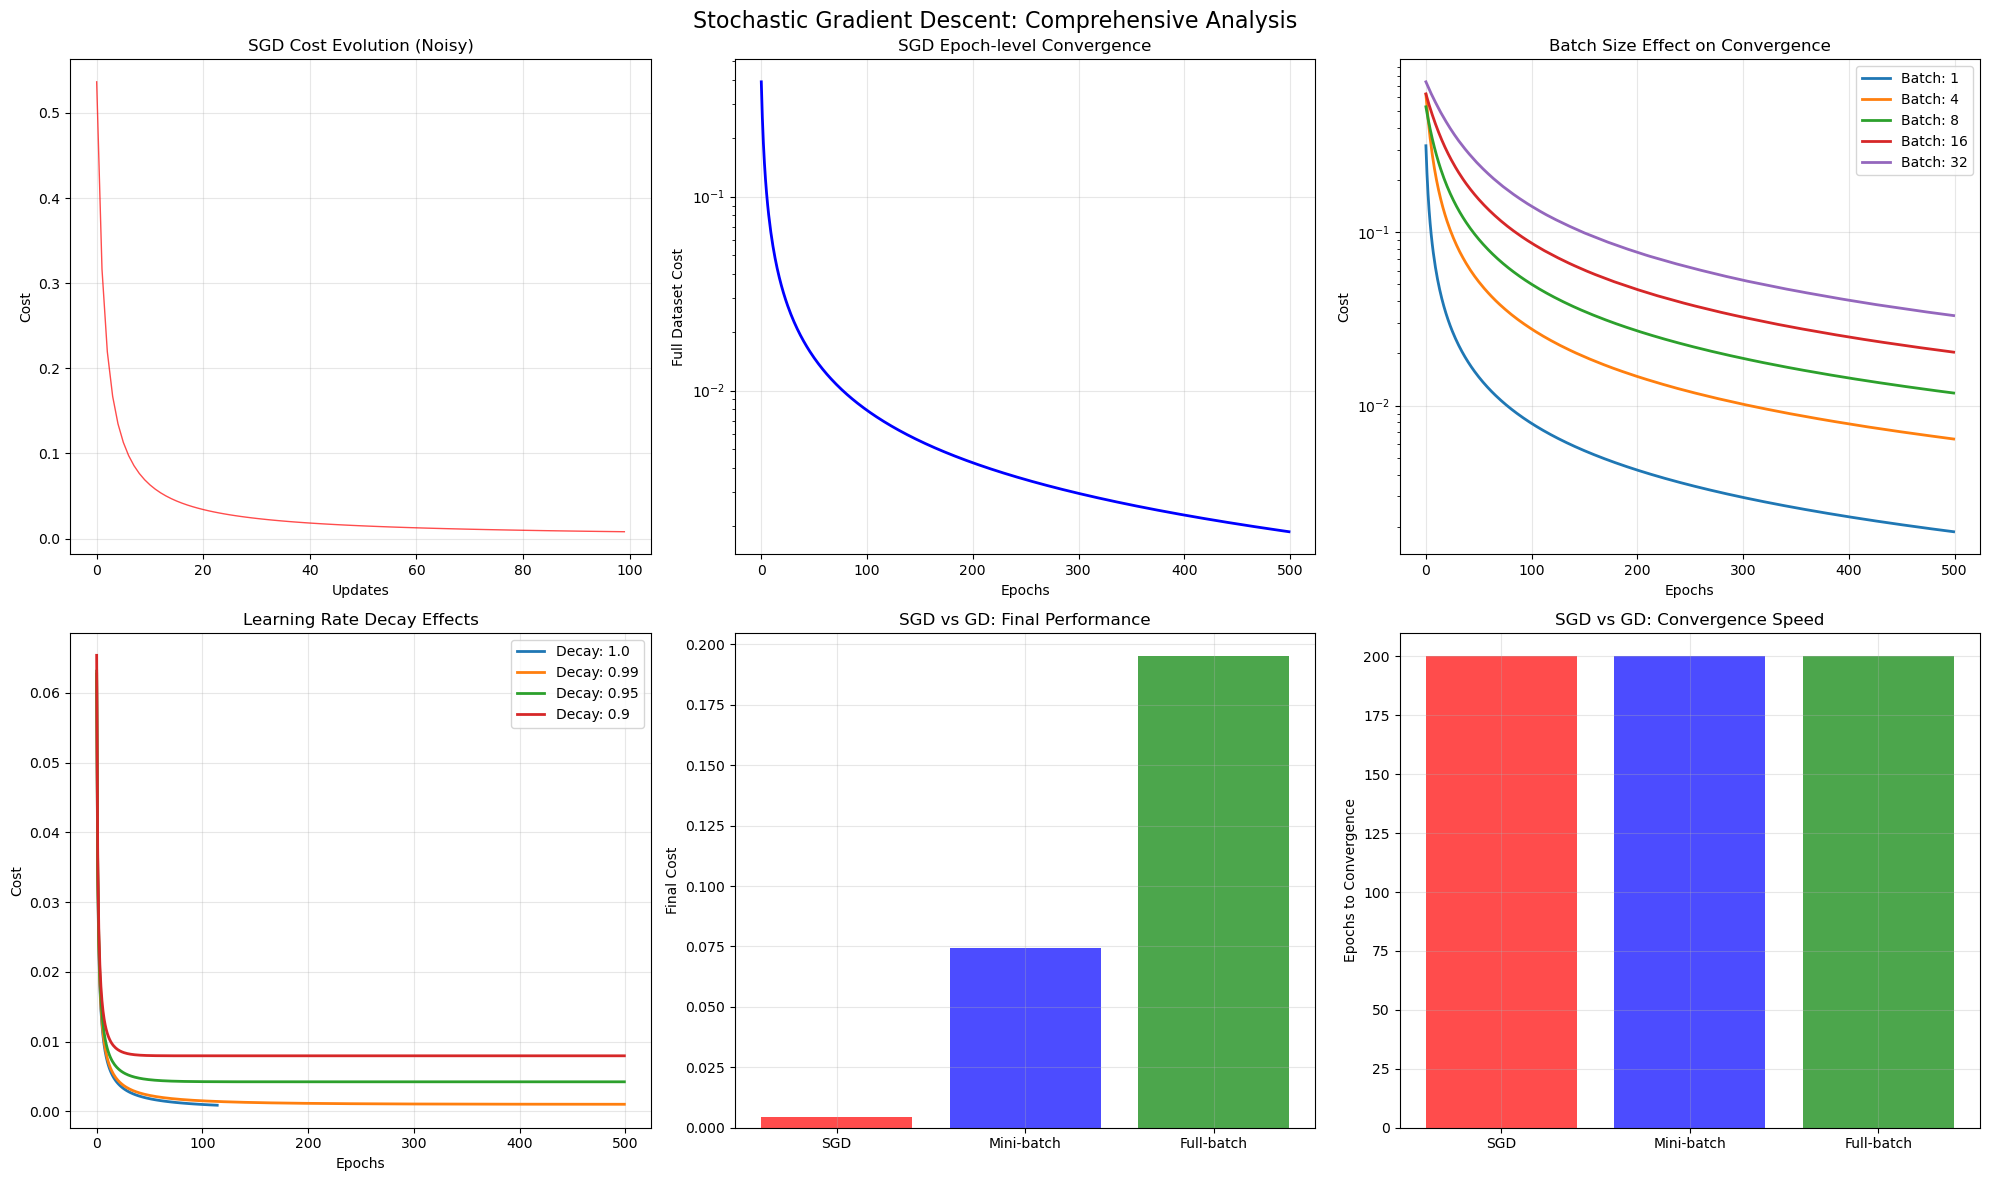


COMPREHENSIVE STOCHASTIC GRADIENT DESCENT ANALYSIS SUMMARY

1. SGD PERFORMANCE:
   • Classification: False convergence in 500 epochs
     Final accuracy: 1.0000
   • Regression: False convergence in 300 epochs
     Final MSE: 0.035140

2. BATCH SIZE ANALYSIS:
   • Best batch size: 1 (lowest final cost)
   • Worst batch size: 32 (highest final cost)
   • Pure SGD (batch=1) epochs: 500
   • Mini-batch (batch=32) epochs: 500

3. LEARNING RATE ANALYSIS:
   • Optimal learning rate for SGD: 0.5
   • Learning rate range tested: 0.001 - 0.5

4. LEARNING RATE DECAY ANALYSIS:
   • Best decay rate: 1.0
   • No decay epochs: 115
   • Best decay epochs: 115

5. SGD VS GRADIENT DESCENT:
   • SGD epochs: 200, Final cost: 0.004267
   • Full-batch GD epochs: 200, Final cost: 0.194992
   • SGD cost variance: Higher (inherent stochasticity)
   • GD cost variance: Lower (deterministic)

6. KEY SGD CHARACTERISTICS OBSERVED:
   • Noisy convergence path (cost fluctuates)
   • Faster initial progress on larg

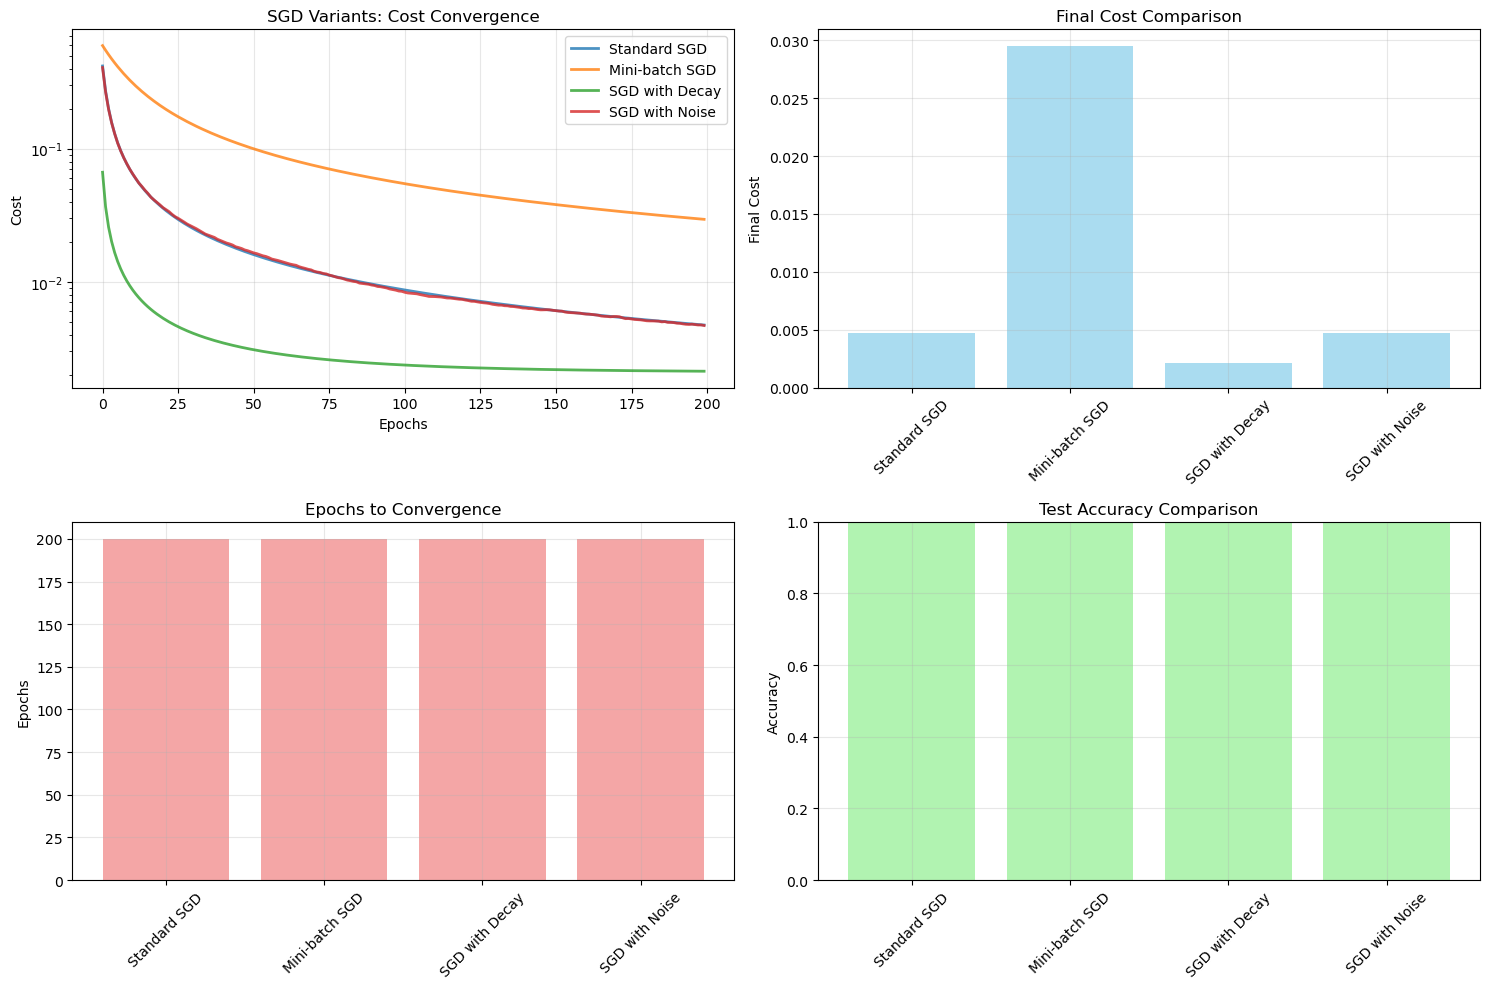


SGD VARIANTS SUMMARY:
  Standard SGD:
    - Epochs: 200, Final cost: 0.004737
    - Test accuracy: 1.0000, Converged: False
  Mini-batch SGD:
    - Epochs: 200, Final cost: 0.029472
    - Test accuracy: 1.0000, Converged: False
  SGD with Decay:
    - Epochs: 200, Final cost: 0.002130
    - Test accuracy: 1.0000, Converged: False
  SGD with Noise:
    - Epochs: 200, Final cost: 0.004696
    - Test accuracy: 1.0000, Converged: False

ALL SGD DEMONSTRATIONS COMPLETED!

Key Takeaways:
1. SGD has noisy but often faster convergence than full-batch GD
2. Mini-batch SGD balances noise reduction with computational efficiency
3. Learning rate decay can improve convergence stability
4. Batch size significantly affects convergence behavior
5. SGD's stochasticity helps escape poor local minima
6. Proper learning rate selection is crucial for SGD success


In [11]:
if __name__ == "__main__":
    print("Starting Comprehensive SGD Analysis...")    
    # Run simple example first
    simple_results = simple_sgd_example()    
    # Run comprehensive analysis
    comprehensive_results = demonstrate_stochastic_gradient_descent()    
    # Run advanced variants
    variant_results = advanced_sgd_variants()
    
    print("\n" + "="*70)
    print("ALL SGD DEMONSTRATIONS COMPLETED!")
    print("="*70)    
    print("\nKey Takeaways:")
    print("1. SGD has noisy but often faster convergence than full-batch GD")
    print("2. Mini-batch SGD balances noise reduction with computational efficiency")
    print("3. Learning rate decay can improve convergence stability")
    print("4. Batch size significantly affects convergence behavior")
    print("5. SGD's stochasticity helps escape poor local minima")
    print("6. Proper learning rate selection is crucial for SGD success")